In [1]:
# Imports
import spectral
import zipfile
import numpy as np
from typing import Union
from pathlib import Path

In [2]:
import sys 
print(sys. version)
print(spectral.__file__)

3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
/home/mha114/miniconda3/envs/massimal/lib/python3.11/site-packages/spectral/__init__.py


In [120]:
# Paths
radiance_cailbration_file = '/media/mha114/Massimal2/seabee-minio/larvik/olbergholmen/aerial/hsi/20230830/massimal_larvik_olbergholmen_202308301228-south-test_hsi/calibration/RadiometricCal100121-278_081220.icp'
raw_image_file = Path('/media/mha114/Massimal2/seabee-minio/larvik/olbergholmen/aerial/hsi/20230830/massimal_larvik_olbergholmen_202308301228-south-test_hsi/0_raw/OlbergholmenN-7/OlbergholmenN_Pika_L_7.bil.hdr')
radiance_dir = Path('/media/mha114/Massimal2/seabee-minio/larvik/olbergholmen/aerial/hsi/20230830/massimal_larvik_olbergholmen_202308301228-south-test_hsi/1_radiance')
radiance_image_file = radiance_dir / raw_image_file.name

In [4]:
def read_envi(header_filename: Union[Path,str], 
              image_filename: Union[Path,str,None]=None,
              write_byte_order_if_missing = True
              ) -> tuple[np.ndarray,np.ndarray,dict]:
    """ Load image in ENVI format, including wavelength vector and other metadata

    Usage:
    ------
    (image,wl,rgb_ind,metadata) = read_envi(header_filename,...)

    Arguments:
    ----------
    header_filename: Path | str
        Path to ENVI file header.

    Keyword arguments:
    ------------------
    image_filename: Path | str
        Path to ENVI data file, useful if data file is not found
        automatically from header file name (see spectral.io.envi.open).
    write_byte_order_if_missing: bool
        Flag to indicate if the string "byte order = 0" should be written
        to the header file in case of MissingEnviHeaderParameter error
        (byte order is required by the "spectral" library, but is missing
        in some Resonon ENVI files)

    Returns:
    --------
    image: np.ndarray
        image, shape (n_lines, n_samples, n_channels) 
    wl: np.ndarray
        Wavelength vector, shape (n_channels,). None if no wavelengths listed. 
    metadata:  dict
        Image metadata (ENVI header content). 
    """

    # Open image handle
    try:
        im_handle = spectral.io.envi.open(header_filename,image_filename)
    except spectral.io.envi.MissingEnviHeaderParameter as e:
        print(f'Header file has missing parameter: {header_filename}')
        print(e)
        byte_order_missing_str = 'Mandatory parameter "byte order" missing from header file.'
        if str(e)==byte_order_missing_str and write_byte_order_if_missing:
            print('Writing "byte order = 0" to header file and retrying')
            try:
                with open(header_filename, 'a') as file:
                    file.write('byte order = 0\n')
            except OSError:
                print(f'Error writing to header file {header_filename}')
            im_handle = spectral.io.envi.open(header_filename,image_filename)
            
    # Read wavelengths
    if 'wavelength' in im_handle.metadata:
        wl = np.array([float(i) for i in im_handle.metadata['wavelength']])
    else:
        wl = None

    # Read data from disk
    image = np.array(im_handle.load())  

    # Returns
    return (image,wl,im_handle.metadata)

In [95]:
def bin_image(image:np.ndarray,
              line_bin_size:int=1, 
              sample_bin_size:int=1,
              channel_bin_size:int=1,
              average:bool=True) -> np.ndarray:
    """ Bin image cube (combine neighboring pixels) 
    
    Inspired by https://stackoverflow.com/a/36102436 
    
    """
    assert image.ndim == 3
    n_lines, n_samples, n_channels = image.shape
    assert (n_lines % line_bin_size) == 0
    assert (n_samples % sample_bin_size) == 0
    assert (n_channels % channel_bin_size) == 0

    n_lines_binned = n_lines // line_bin_size
    n_samples_binned = n_samples // sample_bin_size
    n_channels_binned = n_channels // channel_bin_size

    image = image.reshape(n_lines_binned,line_bin_size,
                          n_samples_binned,sample_bin_size,
                          n_channels_binned,channel_bin_size)
    if average:
        image = np.mean(image,axis=(1,3,5))
    else:
        image = np.sum(image,axis=(1,3,5))

    return image

In [60]:
a = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]],dtype=float)
print(a)
b = np.reshape(a,(2,-1,4))
print(b)
c = np.sum(b,axis=0)
d = np.reshape(c,(2,4))
print(d)

[[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]
 [4. 4. 4. 4.]]
[[[1. 1. 1. 1.]
  [2. 2. 2. 2.]]

 [[3. 3. 3. 3.]
  [4. 4. 4. 4.]]]
[[4. 4. 4. 4.]
 [6. 6. 6. 6.]]


In [71]:
a = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]],dtype=float)
print(a.reshape(2,2,4).sum(0))

[[4. 4. 4. 4.]
 [6. 6. 6. 6.]]


In [73]:
np.sum()

2

In [28]:
class RadianceCalibrationDataset:
    """ A radiance calibration dataset for Resonon hyperspectral cameras.
    
    Attributes:
    -----------
    calibration_file: Path
        Path to Imager Calibration Pack (*.icp) file
    calibration_dir: Path
        Folder into which all the data in the calibration_file
        is put (unzipped).
    gain_file_path: Path
        Path to "gain file", i.e. ENVI file with "gain spectra", 
        per-wavelength values for converting from raw (digital numbers) 
        data to radiance data (in physical units).
    dark_frame_paths: list[Path]
        List of paths to "dark frames", i.e. files with a single line / spectrum
        taken with no light incident on the sensor, taken with different gain
        and shutter values. 

    Methods:
    --------
    get_rad_conv_frame():
        Returns radiance conversion frame, shape (n_samples, n_channels)
    get_closest_dark_frame(gain,shutter)
        Returns dark frame which best matches given gain and shutter values
    
    """

    def __init__(self, calibration_file: Union[Path,str]):
        """ Un-zip calibration file and create radiance calibration dataset 
        
        Arguments:
        ----------
        calibration_file: Path | str
            Path to *.icp Resonon "Imager Calibration Pack" file

        Raises:
        -------
        zipfile.BadZipfile:
            If given *.icp file is not a valid zip file
        
        """
        # Register image calibration "pack" (*.icp) and check that it exists
        self.calibration_file = Path(calibration_file)
        assert self.calibration_file.exists()

        # Unzip into same directory 
        self.calibration_dir = self.calibration_file.parent / 'calibration_frames'
        self.calibration_dir.mkdir(exist_ok=True)
        self._unzip_calibration_file()

        # Register (single) gain curve file and multiple dark frame files
        self.gain_file_path = self.calibration_dir / 'gain.bip.hdr'
        assert self.gain_file_path.exists()
        self.dark_frame_paths = list(self.calibration_dir.glob('offset*gain*shutter.bip.hdr'))

        # Get dark frame gain and shutter info from filenames
        self._get_dark_frames_gain_shutter()

        # Sort gain/shutter values and corresponding filenames 
        self._sort_dark_frame_gains_shutters_paths()



    def _unzip_calibration_file(self,unzip_into_nonempty_dir:bool=False) -> None:
        """ Unzip *.icp file (which is a zip file) """
        if not unzip_into_nonempty_dir and any(list(self.calibration_dir.iterdir())): 
            print(f'INFO: Non-empty calibration directory {self.calibration_dir}')
            print('INFO: Skipping unzipping of calibration file, assuming unzipping already done.') 
            return
        try:
            with zipfile.ZipFile(self.calibration_file, mode='r') as zip_file:
                for filename in zip_file.namelist():
                    zip_file.extract(filename, self.calibration_dir)
        except zipfile.BadZipFile:
            print(f'File {self.calibration_file} is not a valid ZIP file.')
        except Exception as e:
            print('An unexpected error occured when extracting calibration file '
                  f'{self.calibration_file}')
            print(e)
            

    def _get_dark_frames_gain_shutter(self) -> None:
        """ Extract and save gain and shutter values for each dark frame """
        # Example dark frame pattern: 
        # offset_600bands_4095ceiling_5gain_900samples_75shutter.bip.hdr
        dark_frame_gains = []
        dark_frame_shutters = []
        for dark_frame_path in self.dark_frame_paths:
            # Strip file extensions, split on underscores, keep only gain and shutter info
            _, _, _, gain_str, _, shutter_str = dark_frame_path.name.split('.')[0].split('_')
            dark_frame_gains.append(int(gain_str[:-4]))
            dark_frame_shutters.append(int(shutter_str[:-7]))
        # Save as NumPy arrays
        self._dark_frame_gains = np.array(dark_frame_gains,dtype=float)
        self._dark_frame_shutters = np.array(dark_frame_shutters,dtype=float)

    def _sort_dark_frame_gains_shutters_paths(self) -> None:
        """ Sort gain/shutter values and corresponding file names """
        gain_shutter_path_sorted = sorted(zip(
            self._dark_frame_gains, self._dark_frame_shutters, self.dark_frame_paths))
        self._dark_frame_gains = np.array([gain for gain,_,_ in gain_shutter_path_sorted])
        self._dark_frame_shutters = np.array([shutter for _,shutter,_ in gain_shutter_path_sorted])
        self.dark_frame_paths = [path for _,_,path in gain_shutter_path_sorted]

            
    def _get_closest_dark_frame_path(self, 
                               gain: Union[int,float], 
                               shutter: Union[int,float]
                               ) -> Path:
        """ Search for dark frame with best matching gain and shutter values """
        # First search for files with closest matching gain
        candidate_gains = np.unique(self._dark_frame_gains)
        closest_gain = candidate_gains[np.argmin(abs(candidate_gains - gain))]
        
        # Then search (in subset) for single file with closest matching shutter 
        candidate_shutters = np.unique(self._dark_frame_shutters[self._dark_frame_gains == closest_gain])
        closest_shutter = self._dark_frame_shutters[np.argmin(abs(candidate_shutters - shutter))]
        
        # Return best match
        best_match_mask = ((self._dark_frame_gains==closest_gain) & 
                           (self._dark_frame_shutters==closest_shutter))
        best_match_ind = np.nonzero(best_match_mask)[0]
        assert len(best_match_ind) == 1 # There should only be a single best match
        return self.dark_frame_paths[best_match_ind[0]], closest_gain, closest_shutter
        
    def get_closest_dark_frame(self, 
                               gain: Union[int,float], 
                               shutter: Union[int,float]
                               ) -> tuple[np.ndarray, np.ndarray, dict, float, float]:
        """ Get dark frame which most closely matches given gain and shutter values 
        
        Arguments:
        ----------
        gain:
            Gain value used for search, typically gain value of image that should
            be converted from raw to radiance. Values follow Resonon convention 
            used in header files++ (logarithmic values, 20 log10).
        shutter:
            Shutter value used for search, typically shutter value of image that should
            be converted from raw to radiance. Values follow Resonon convention 
            used in header files++ (unit: milliseconds).

        Returns:
        --------
        frame: np.ndarray
            Single dark frame, shape (1,n_samples,n_channels)
        wl: np.ndarray 
            Vector of wavelengths for each spectral channel (nanometers)
        metadata: dict
            Metadata from ENVI header, formatted as dictionary
        """
        closest_file, closest_gain, closest_shutter = self._get_closest_dark_frame_path(
            gain=gain,shutter=shutter)
        frame, wl, metadata = read_envi(closest_file)
        return frame, wl, metadata, closest_gain, closest_shutter


    def get_rad_conv_frame(self) -> tuple[np.ndarray, np.ndarray, dict]:
        """ Read and return radiance conversion curve ("gain" file) 
        
        Returns:
        --------
        frame: np.ndarray
            Radiance conversion frame, shape (1,n_samples,n_channels)
        wl: np.ndarray 
            Vector of wavelengths for each spectral channel (nanometers)
        metadata: dict
            Metadata from ENVI header, formatted as dictionary
        
        """
        return read_envi(self.gain_file_path)  

In [29]:
rd = RadianceCalibrationDataset(radiance_cailbration_file)

INFO: Non-empty calibration directory /media/mha114/Massimal2/seabee-minio/larvik/olbergholmen/aerial/hsi/20230830/massimal_larvik_olbergholmen_202308301228-south-test_hsi/calibration/calibration_frames
INFO: Skipping unzipping of calibration file, assuming unzipping already done.


In [31]:
dark_frame,wl,metadata,gain,shutter = rd.get_closest_dark_frame(gain=5,shutter=4.819)
print(metadata)

{'interleave': 'bip', 'lines': '1', 'samples': '900', 'bands': '600', 'data type': '12', 'shutter': '5', 'gain': '5.0', 'ceiling': '4095', 'sample binning': '1', 'spectral binning': '1', 'byte order': '0'}


In [32]:
rad_conv_frame,wl,metadata = rd.get_rad_conv_frame()

In [33]:
rad_conv_frame.shape

(1, 900, 600)

In [108]:
class RadianceConverter:

    def __init__(self, radiance_calibration_file: Union[Path,str]=None):
        
        # Set radiance calibration file
        if radiance_calibration_file is None:
            icp_files = [self.raw_data_dir.glob('*.icp')]
            if len(icp_files) == 0:
                raise FileNotFoundError(f'No calibration file (*.icp) found in {self.raw_data_dir}')
            elif len(icp_files) > 1:
                raise ValueError(f'More than one calibration file (*.icp) found in {self.raw_data_dir}')
            self.radiance_calibration_file = icp_files[0]
        else:
            self.radiance_calibration_file = radiance_calibration_file

        # Create radiance calibration dataset
        self.rc_dataset = RadianceCalibrationDataset(calibration_file=radiance_calibration_file)
        
        # Get radiance conversion frame (same for all images)
        self._get_rad_conv_frame()

    def _get_rad_conv_frame(self) -> None:
        rad_conv_frame,_,rad_conv_metadata = self.rc_dataset.get_rad_conv_frame()
        assert rad_conv_metadata['sample binning'] == '1'
        assert rad_conv_metadata['spectral binning'] == '1'
        assert rad_conv_metadata['samples'] == '900'
        assert rad_conv_metadata['bands'] == '600'
        self.rad_conv_frame = rad_conv_frame
        self.rad_conv_metadata = rad_conv_metadata


    def _get_best_matching_dark_frame(self, raw_image_metadata: dict) -> tuple[np.ndarray,dict]:
        dark_frame,_,dark_frame_metadata,_,_ = self.rc_dataset.get_closest_dark_frame(
            gain=float(raw_image_metadata['gain']), shutter=float(raw_image_metadata['shutter']))
        return (dark_frame, dark_frame_metadata)

    def _get_scaled_dark_frame(self, 
                               dark_frame: np.ndarray,
                               dark_frame_metadata:dict,
                               raw_image_metadata:dict
                               ) -> np.ndarray:
        assert dark_frame_metadata['sample binning'] == '1'
        assert dark_frame_metadata['spectral binning'] == '1'
        binning_factor = (float(raw_image_metadata['sample binning']) * 
                          float(raw_image_metadata['spectral binning']))
        dark_frame = bin_image(dark_frame,
                               sample_bin_size=int(raw_image_metadata['sample binning']),
                               channel_bin_size=int(raw_image_metadata['spectral binning']))
        dark_frame = dark_frame * binning_factor

        return dark_frame
    
    def _get_scaled_rad_conv_frame(self,raw_image_metadata:dict) -> np.ndarray:
        # Scaling due to binning
        binning_factor = 1.0 / (float(raw_image_metadata['sample binning']) * 
                                float(raw_image_metadata['spectral binning']))

        # Scaling due to gain differences
        rad_conv_gain = 10**(float(self.rad_conv_metadata['gain']) / 20.0)
        input_gain = 10**(float(raw_image_metadata['gain']) / 20.0)
        gain_factor = rad_conv_gain / input_gain
        
        # Scaling due to shutter differences
        rad_conv_shutter = float(self.rad_conv_metadata['shutter'])
        input_shutter = float(raw_image_metadata['shutter'])
        shutter_factor = rad_conv_shutter / input_shutter

        # Bin (average) radiance conversion frame to have same dimensions as input
        rad_conv_frame = bin_image(self.rad_conv_frame,
                                   sample_bin_size=int(raw_image_metadata['sample binning']),
                                   channel_bin_size=int(raw_image_metadata['spectral binning']),
                                   average=True) 

        # Combine factors and scale frame
        scaling_factor = binning_factor * gain_factor * shutter_factor
        rad_conv_frame = rad_conv_frame * scaling_factor

        return rad_conv_frame
        

    def convert_raw_image_to_radiance(self, 
                                      raw_image: np.ndarray,
                                      raw_image_metadata: dict
                                      ) -> np.ndarray:
        
        # Get dark frame and radiance conversion frames scaled to input image
        dark_frame, dark_frame_metadata = self._get_best_matching_dark_frame(raw_image_metadata)
        dark_frame = self._get_scaled_dark_frame(dark_frame, dark_frame_metadata,raw_image_metadata)
        rad_conv_frame = self._get_scaled_rad_conv_frame(raw_image_metadata)

        # Flip frames if necessary
        if (('flip radiometric calibration' in raw_image_metadata ) and
            (raw_image_metadata['flip radiometric calibration'] == 'True')):
            dark_frame = np.flip(dark_frame,axis=1) 
            rad_conv_frame = np.flip(rad_conv_frame,axis=1)

        # Subtract dark current and convert to radiance (microflicks)
        radiance_image = (raw_image - dark_frame) * rad_conv_frame

        # Set negative (non-physical) values to zero
        radiance_image[radiance_image>0] = 0

        # Convert to 16-bit integer format (more efficient for storage)
        return radiance_image.astype(np.int16)
    
    # def read_convert_save_image(self,
    #                             raw_image_header_path: Union[Path,str],
    #                             radiance_image_header_path: Union[Path,str]
    #                             ) -> None:

        


In [109]:
rc = RadianceConverter(radiance_calibration_file=radiance_cailbration_file)

INFO: Non-empty calibration directory /media/mha114/Massimal2/seabee-minio/larvik/olbergholmen/aerial/hsi/20230830/massimal_larvik_olbergholmen_202308301228-south-test_hsi/calibration/calibration_frames
INFO: Skipping unzipping of calibration file, assuming unzipping already done.


In [98]:
raw_image,wl,raw_image_metadata = read_envi(raw_image_file)

In [110]:
rad_image = rc.convert_raw_image_to_radiance(raw_image,raw_image_metadata)

binning_factor=2.0
np.min(dark_frame)=0.0, np.max(dark_frame)=28.0
scaling_factor=0.3381470704783325
np.min(rad_conv_frame)=1.8560379, np.max(rad_conv_frame)=280.30212


In [102]:
print(f'{rad_image.shape=}')
print(f'{np.min(raw_image)=}, {np.max(raw_image)=}')
print(f'{np.min(rad_image)=}, {np.max(rad_image)=}')

rad_image.shape=(2000, 900, 300)
np.min(raw_image)=0.0, np.max(raw_image)=2722.0
np.min(rad_image)=-2681.942, np.max(rad_image)=7515.4995


In [114]:
import massimal.image_render
import massimal.hyspec_io
import matplotlib.pyplot as plt

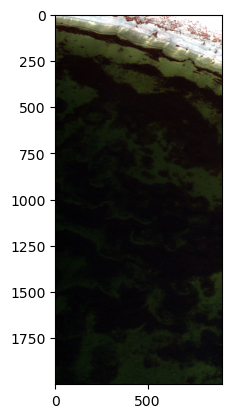

In [112]:
plt.imshow(massimal.image_render.percentile_stretch(rad_image[:,:,(150,100,50)]))

In [121]:
massimal.hyspec_io.save_envi_image(radiance_image_file,rad_image,raw_image_metadata)